In [1]:
import numpy as np
import pandas as pd
from scipy import interpolate

import xarray as xr
import dask.array as da
from dask.distributed import Client

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches # for creating legend
import matplotlib.dates as mdates # converts datetime64 to datetime

import cartopy
import cartopy.crs as ccrs # for plotting
import cartopy.feature as cfeature # for map features
from cartopy.util import add_cyclic_point # for wrapping map fully - avoiding white line on 0 deg
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import matplotlib.dates as mdates # converts datetime64 to datetime
import matplotlib.gridspec as gridspec # to create grid-shaped combos of axes
from mpl_toolkits import mplot3d # 3d plotting tool
import cmocean # for nice oceanography colour pallettes

#import argopy
#from argopy import DataFetcher as ArgoDataFetcher # to load Argo ds directly

import os # for finding files

import gsw # for conversion functions

from tqdm.notebook import tqdm_notebook as tqdm
import glob # for downloading data
import sys # for path to functions

import seaborn as sns

sns.set(#font='Helvetica',
        rc={
         'axes.axisbelow': False,
         'axes.edgecolor': 'Black',
         'axes.facecolor': 'w', 
                            # '#aeaeae',
         'axes.grid': False,
         'axes.labelcolor': 'k',
         'axes.spines.right': True,
         'axes.spines.top': True,
         'figure.facecolor': 'white',
         'lines.solid_capstyle': 'round',
         'patch.edgecolor': 'k',
         'patch.force_edgecolor': True,
         'text.color': 'k',
         'xtick.bottom': True,
         'xtick.color': 'k',
         'xtick.direction': 'out',
         'xtick.top': False,
         'ytick.color': 'k',
         'ytick.direction': 'out',
         'ytick.left': True,
         'ytick.right': False},
         font_scale=1)
mpl.rcParams["figure.titlesize"] = 25
mpl.rcParams["axes.titlesize"] = 22
mpl.rcParams["axes.labelsize"] = 20
mpl.rcParams["font.size"] = 18
mpl.rcParams["xtick.labelsize"] = 18
mpl.rcParams["ytick.labelsize"] = 18
mpl.rcParams["ytick.labelright"] = False

from warnings import filterwarnings as fw
fw('ignore')

# import my own funcs
import sys
sys.path.append('/home/theospira/notebooks/projects/01-WW_climatology/functions')
from plot_formatting import circular_boundary,plot_nice_box
from inspection_funcs import boxplot

import importlib
#importlib.reload(sys.modules['inspection_plot'])

In [2]:
from matplotlib.dates import AutoDateLocator

sys.path.append('/home/theospira/notebooks/projects/03-WW-timeseries/funcs')
from plotting import *
from computations import *
from import_data import *

# ML properties: supplementary

## load data

In [3]:
cmap_br = get_cmap()
from plot_formatting import plot_gridlines
from smoothing_and_interp import wrap_smth_var,nan_interp

def compute_n2_decomposed(ds):

    # pull variables
    SA = ds.asal.data
    CT = ds.ctemp.data
    p  = ds.pres.data
    
    alpha = gsw.alpha(SA, CT, p)
    beta  = gsw.beta(SA, CT, p)
    g = -9.81
    
    # compute n2_t and n2_s:
    n2_t,n2_s  = np.ndarray(ds.ctemp.shape)*np.nan,np.ndarray(ds.ctemp.shape)*np.nan
    n2_t[:,1:] = ds.ctemp.diff('pres') * alpha[:,1:] * g
    n2_s[:,1:] = ds.asal.diff('pres')  * beta[:,1:] * -g

    
    ds['n2_t'] = xr.DataArray(n2_t,
                              dims   = {'n_prof':ds.n_prof.data,'pres':ds.pres.data},
                              coords = {'n_prof':ds.n_prof.data,'pres':ds.pres.data},)
    ds['n2_s'] = xr.DataArray(n2_s,
                              dims   = {'n_prof':ds.n_prof.data,'pres':ds.pres.data},
                              coords = {'n_prof':ds.n_prof.data,'pres':ds.pres.data},)

    return ds

In [4]:
d_path='/home/theospira/notebooks/projects/03-WW-timeseries/data/hydrographic_profiles/'
ds = xr.open_dataset(d_path+'gridded-timeseries-ww-recalc1.nc')

# mask data and compute mixed layer anomalies
tmp = mask_data(ds,vars=['ww_ct','ml_s','ml_t','mlp'])
ml_vars = ['mlp','ml_t','ml_s',]
for v in ml_vars:
    tmp = calc_mean_var(tmp,v)
    tmp[v+'_anm'] = tmp[v]-tmp[v+'_mn']

# load sea ice data
si = load_sea_ice()
si = si.sel(lat=slice(-80,-52)).sel(time=slice('2005-01-01','2022-01-01'))
si = calc_mean_var(si,'sia')
si = calc_mean_var(si,'sic')

contains ww_ct


## compute $SCI = \frac{N^2_{\theta} - N^2_S}{N^2}$

In [5]:
# load data
ds_prof = xr.open_dataset(d_path+'hydrographic_profiles_1.nc')

# compute n2, thermal and saline contributions, and SCI
ds_prof = compute_n2_decomposed(ds_prof)
n2 = ds_prof[['n2','n2_t','n2_s']].where(ds_prof.pres<ds_prof.mlp).mean('pres')
n2['sci'] = (n2.n2_t - n2.n2_s)/n2.n2

# grid stratification index, calc anomaly and mask to SIZ
from gridding import vincents_median_grid_var
sci = vincents_median_grid_var(n2.sci.isel(n_prof=np.where(n2.sci.notnull())[0]))
sci = calc_mean_var(sci,'sci')
sci['sci_anm'] = sci.sci - sci.sci_mn
sci_msk = mask_data(sci)

adding ww_ct


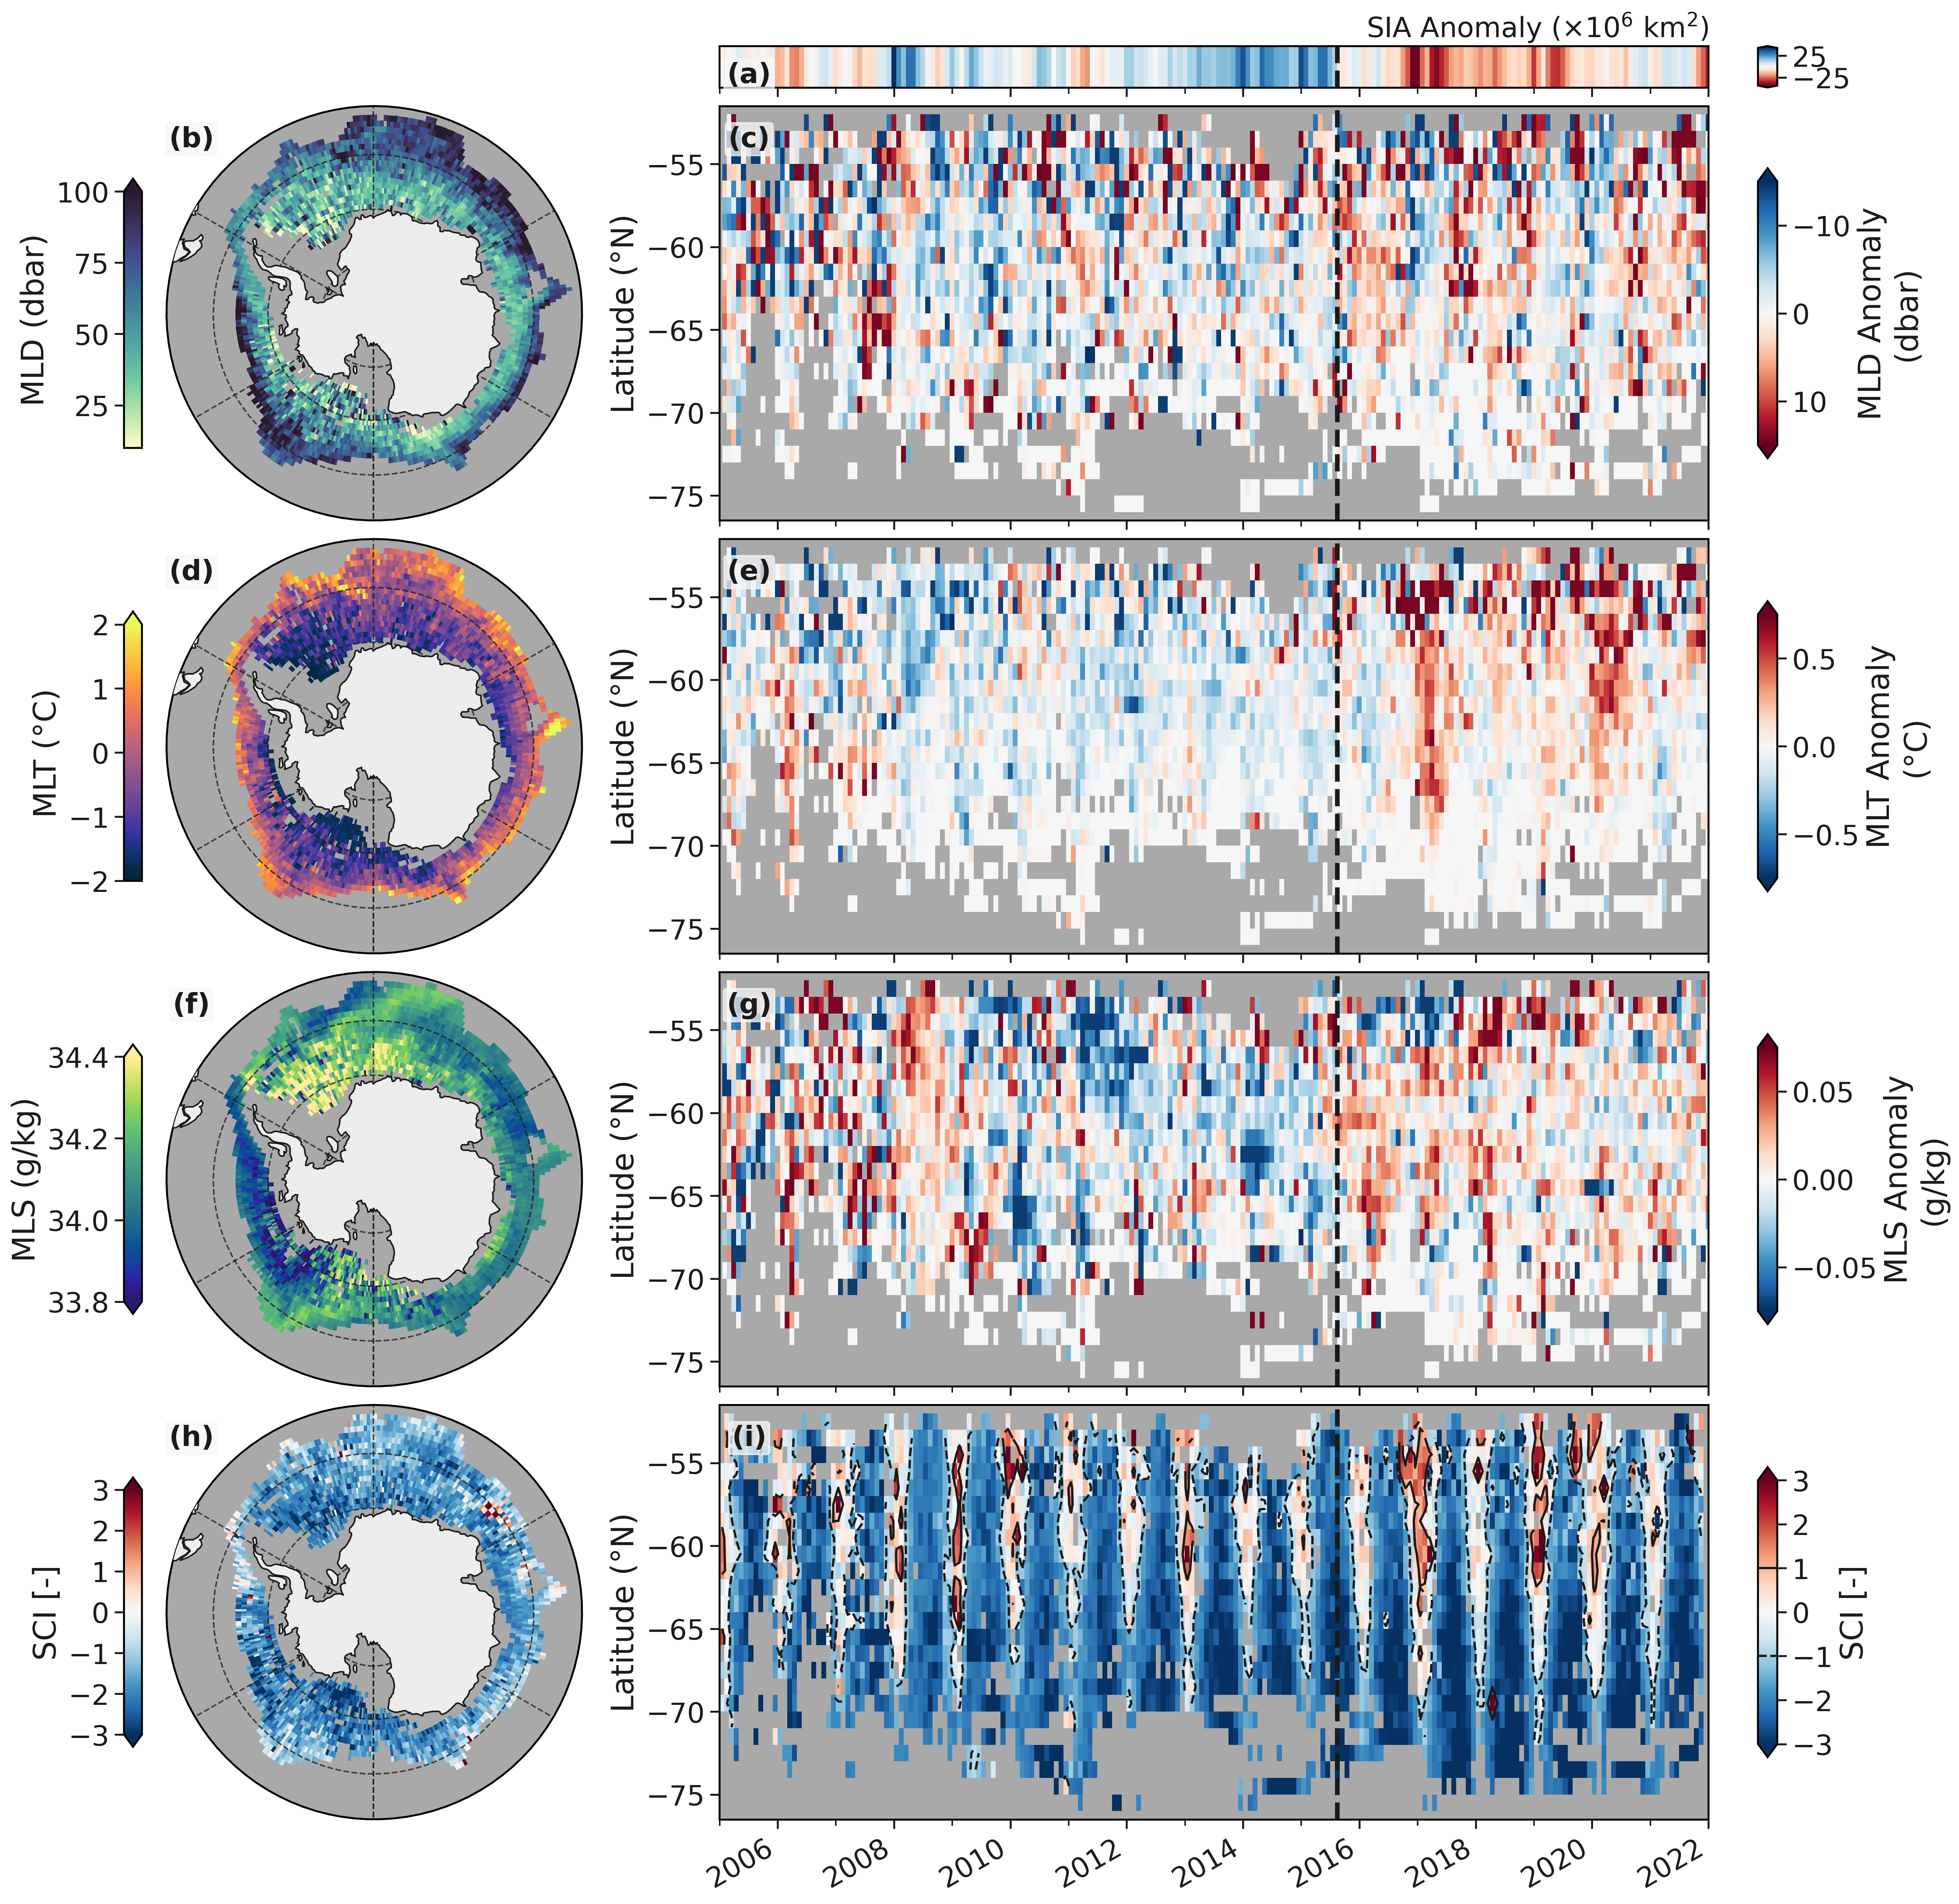

In [9]:
r,c = 5,2
fig = plt.figure(figsize=(17.5, 17), constrained_layout=True, dpi=300)
gs = gridspec.GridSpec(r, c, figure=fig, width_ratios=[1.5, 3.5], height_ratios=[0.1,1,1,1,1])
crs = ccrs.PlateCarree()

# Create subplots for the first row (excluding the colorbar space)
ax = []

# define this for use in plots
label = ['MLD',r'MLT',r'MLS']
units = ['dbar','°C','g/kg']

# plot a 1D heatmap at the top of the figure
ax.append(fig.add_subplot(gs[0, 1]))
plot_sea_ice_climate_stripes(si,ax[0],fig,aspect=((20/0.7)*0.1 * (3/4)),)# pad=0.028)

# Create subplots for the second and third rows
for j in range(r-1):
    ax.append(fig.add_subplot(gs[j+1, 0],projection=ccrs.SouthPolarStereo()))

    # format figures
    a = ax[-1]
    circular_boundary(a)
    a.set_extent([0,360,-90,-51.5],crs=crs)
    a.add_feature(cfeature.LAND,zorder=9,facecolor="#ededed",)
    a.coastlines(zorder=10,color="k") # shows continental coastline
    a.set_facecolor('darkgrey')
    plot_gridlines(a,color='k',)

# kwargs for circumpolar plots
kwargs = dict(x='lon',transform=crs,)
cb_kw = {'aspect':15,'shrink':0.65,'location':'left',} # 'pad':0.028}
#wrap_smth_var(nan_interp(
tmp.mlp.mean('time').plot(**kwargs,cmap='cmo.deep',vmax=100,ax=ax[1],
                          cbar_kwargs={**cb_kw,'label':label[0]+' ('+units[0]+')'})
tmp.ml_t.mean('time').plot(**kwargs,cmap='cmo.thermal',vmin=-2,vmax=2,ax=ax[2],
                           cbar_kwargs={**cb_kw,'label':label[1]+' ('+units[1]+')'})
tmp.ml_s.mean('time').plot(**kwargs,cmap='cmo.haline',vmin=33.8,vmax=34.4,ax=ax[3],
                           cbar_kwargs={**cb_kw,'label':label[2]+' ('+units[2]+')'})
cb = sci_msk.sci.mean('time').plot(**kwargs,ax=ax[4],cmap=cmap_br,vmin=-3,#levels=7,
                                   cbar_kwargs={**cb_kw,'label':'SCI [-]','ticks':np.arange(-3,3.1,1)}
                                  ).colorbar
cb.minorticks_off()

# plot hovmollers
for j in range(r-1):
    ax.append(fig.add_subplot(gs[j+1, 1]))
    ax[-1].set_facecolor('darkgrey')

# define cbar_kwargs:
cb_kw = dict(extend='both',shrink=0.7,aspect=15)

vmax  = [15,0.75,0.075]
for v,a,vm,l,u in zip(ml_vars,ax[r:-1],vmax,label,units):
    # change extremes so they are discernable on plot
    tmp2 = (tmp[v]-tmp[v+'_mn']).mean('lon')
    tmp2 = tmp2.where(~((tmp2 > vm )), other=0.95*vm)
    tmp2 = tmp2.where(~((tmp2 < -vm)), other=0.95*-vm)
    hvm  = tmp2.plot(x='time',cmap=cmap_br,ax=a,vmin=-vm,vmax=vm,
                    cbar_kwargs={**cb_kw,'label':l+' Anomaly\n('+u+')'})
    if l=='MLD':
        hvm.colorbar.ax.invert_yaxis()
    a.set_xlabel('')

# plot stratification control index
cb = sci_msk.sci.mean('lon').plot(x='time',ax=ax[-1],cmap=cmap_br,vmin=-3,#levels=7,
                             cbar_kwargs={**cb_kw,'label':'SCI [-]','ticks':np.arange(-3,3.1,1)}
                            ).colorbar
sci_msk.sci.mean('lon').plot.contour(x='time',ax=ax[-1],levels=[1,-1],colors=['k'],)

# 
cb.ax.axhline(1,ls='-',c='k')
cb.ax.axhline(-1,ls='--',c='k')

for a in ax[r:]:
    si_timeseries_plot_formatting(a,lw=3)
    a.set_ylim(-76.5,-51.5)
    a.set_ylabel('Latitude (°N)')
for a in np.append(ax[0],ax[4:-1]):
    a.set_xticklabels('')
si_timeseries_plot_formatting(ax[0],lw=3)

# add figure labels
# for circumpolar plots
for j,a in enumerate(ax[1:r]):
    j = j*2
    fig_labels(a_x=0.06,a_y=0.92,ax=a,j=j+1,fs=18)
# for time series plot
for j,a in enumerate(ax[r:]):
    j = j*2 + 1
    fig_labels(0.03,.92,ax=a,j=j+1,fs=18)
# for sea ice bar
fig_labels(0.03,.3,ax=ax[0],j=0,fs=18)